In [323]:
import warnings
warnings.filterwarnings('ignore')

In [362]:
from pathlib import Path
import os

from tqdm.notebook import tqdm
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import matplotlib.lines as mlines
from skimage.measure import label, find_contours
%matplotlib inline

from dpipe.io import load, save

In [415]:
pred_path = Path('/shared/experiments/ood_playground/cc359/brain_segm/visualization/')

# pred_ids = ('CC0241', 'CC0201')
# pred_ids = ('CC0241', '10')
# pred_ids = ('CC0241', 'CC0241')

# pred_ids = ('1.3.6.1.4.1.14519.5.2.1.6279.6001.270152671889301412052226973069', '1.2.826.0.1.3680043.10.474.1147302139452080037190733417686299226')
# pred_ids = ('1.3.6.1.4.1.14519.5.2.1.6279.6001.270152671889301412052226973069', '1.3.6.1.4.1.14519.5.2.1.6279.6001.270152671889301412052226973069')

# pred_ids = ('1.2.826.0.1.3680043.10.474.1147302139452080037190733417686299226', '1.2.826.0.1.3680043.10.474.1147302139452080037190733417686299226')
pred_ids = ('1.2.826.0.1.3680043.10.474.1147302139452080037190733417686299226', '5')


id2pair = {_id: pair for _id, pair in zip(pred_ids, (pred_ids, pred_ids))}

image_fname_template = 'image_{}.npy'

label2fname_template = {
    'Prediction': 'pred_{}.npy',
    'Ground truth': 'mask_{}.npy',
}

label2color = {k: c for k, c in zip(label2fname_template.keys(),
                                    ('orange', 'blue', ))}

In [391]:
def pad_if(img, _if=False, default_size=512):
    if _if:
        diff = default_size - img.shape[-1]
        img = np.pad(img, [[0, 0], [0, 0], [diff // 2, diff // 2 + diff % 2]], mode='constant',
                     constant_values=np.min(img))
    return img


def load_pack(_id, pad=False):
    smooth, sharp = id2pair[_id]
    
    image_smooth = pad_if(np.clip(load(pred_path / _id / image_fname_template.format(smooth)), -1250, 250), pad)
    image_sharp = pad_if(np.clip(load(pred_path / _id / image_fname_template.format(sharp)), -1250, 250), pad)
    
    label2mask_smooth = {k: pad_if(np.float32(load(pred_path / _id / v.format(smooth)) > 0.5), pad)
                         for k, v in label2fname_template.items()}
    label2mask_sharp = {k: pad_if(np.float32(load(pred_path / _id / v.format(sharp)) > 0.5), pad)
                        for k, v in label2fname_template.items()}
    
    label2maskfull_smooth = {k: pad_if(np.float32(load(pred_path / _id / v.format(smooth))), pad)
                         for k, v in label2fname_template.items()}
    label2maskfull_sharp = {k: pad_if(np.float32(load(pred_path / _id / v.format(sharp))), pad)
                        for k, v in label2fname_template.items()}
    
    return image_smooth, image_sharp, label2mask_smooth, label2mask_sharp, label2maskfull_smooth, label2maskfull_sharp

In [392]:
from typing import Union, Callable
from matplotlib.colors import Colormap
from dpipe.im.axes import AxesParams
from dpipe.checks import check_shape_along_axis


def _get_rows_cols(max_cols, data):
    columns = min(len(data), max_cols or len(data))
    return (len(data) - 1) // columns + 1, columns


def _slice_base(data: [np.ndarray], label2mask_smooth=None, label2mask_sharp=None,
                axis: int = -1, scale: int = 5, max_columns: int = None, colorbar: bool = False,
                show_axes: bool = False, cmap: Union[Colormap, str] = 'gray', vlim: AxesParams = None,
                callback: Callable = None, sliders: dict = None):
    from ipywidgets import interact, IntSlider
    
    check_shape_along_axis(*data, axis=axis)
    vlim = np.broadcast_to(vlim, [len(data), 2]).tolist()
    rows, columns = _get_rows_cols(max_columns, data)
    sliders = sliders or {}
    if 'idx' in sliders:
        raise ValueError(f'Overriding "idx" is not allowed.')

    def update(idx, **kwargs):
        fig, axes = plt.subplots(rows, columns, figsize=(scale * columns, scale * rows))
        for i, (ax, x, (vmin, vmax)) in enumerate(zip(np.array(axes).flatten(), data, vlim)):
            im = ax.imshow(x.take(idx, axis=axis), cmap=cmap, vmin=vmin, vmax=vmax)
            
            # ('#7209B7', '#E67F0D', '#E83F6F', '#FFBF00', '#86BBD8', )
            label2color = {k: c for k, c in zip(label2mask_smooth.keys(),
                                                ('#DDFFF7', '#E83F6F', ))}
                                                # ('#DDFFF7', '#E83F6F', 'royalblue', '#FFBF00', ))}
            
            
            lines_smooth = [mlines.Line2D([], [], color=label2color[lbl], linestyle='-',
                                          label=lbl, linewidth=3) for lbl in label2mask_smooth.keys()]
            # lines_sharp = [mlines.Line2D([], [], color=label2color[lbl], linestyle=':',
            #                              label=lbl, linewidth=3) for lbl in label2mask_sharp.keys()]
            lines_sharp = [mlines.Line2D([], [], color=label2color[lbl], linestyle='-',
                                         label=lbl, linewidth=3) for lbl in label2mask_sharp.keys()]
            if i == 0:
                ax.legend(handles=lines_smooth, fontsize=16)
            else:
                ax.legend(handles=lines_sharp, fontsize=16)
            
            # contours:
            if i == 0:
                lw = 2
                for lbl, mask in list(label2mask_smooth.items()):
                    cs = find_contours(mask.take(idx, axis=axis), 0.5)
                    for c in cs:
                        ax.plot(c.T[1], c.T[0], color=label2color[lbl], linestyle='-', linewidth=lw)
                        
            else:  # i == 1:
                lw = 2
                for lbl, mask in list(label2mask_sharp.items()):
                    cs = find_contours(mask.take(idx, axis=axis), 0.5)
                    for c in cs:
                        ax.plot(c.T[1], c.T[0], color=label2color[lbl], linestyle='-', linewidth=lw)
                # pi, ps = 12, 6
                # for lbl, mask in list(label2mask_sharp.items()):
                    # cs = find_contours(mask.take(idx, axis=axis), 0.5)
                    # for c in cs:
                        # ax.scatter(c.T[1][::pi], c.T[0][::pi], c=label2color[lbl], s=ps)
                        # # ax.plot(c.T[1], c.T[0], color=label2color[lbl], linestyle='-', linewidth=lw)
            
            if colorbar:
                fig.colorbar(im, ax=ax, orientation='horizontal')
            if not show_axes:
                ax.set_axis_off()

        if callback is not None:
            callback(axes, idx=idx, **kwargs)

        plt.tight_layout()
        plt.show()

    interact(update, idx=IntSlider(min=0, max=data[0].shape[axis] - 1, continuous_update=False), **sliders)


def slice3d_c(*data: np.ndarray, label2mask_smooth=None, label2mask_sharp=None,
              axis: int = -1, scale: int = 5, max_columns: int = None, colorbar: bool = False,
              show_axes: bool = False, cmap: Union[Colormap, str] = 'gray', vlim: AxesParams = None):
    
    _slice_base(data, label2mask_smooth, label2mask_sharp,
                axis, scale, max_columns, colorbar, show_axes, cmap, vlim)

In [393]:
def plot_contour(ax, mask, lbl, idx, axis=-1, t=False):
    # label2color = {k: c for k, c in zip(label2mask_smooth.keys(),
    #                                     ('#DDFFF7', '#E83F6F', ))}
                                        # ('#6DA34D', '#E83F6F', 'royalblue', '#FFBF00', ))}
    
    
    line = mlines.Line2D([], [], color=label2color[lbl], linewidth=7, linestyle='-', label=lbl)
    
    mask = mask.take(idx, axis=axis)
    mask = mask.T if t else mask
    cs = find_contours(mask, 0.5)
#     if label2ls[lbl] == ':':
#         pi, ps = 7, 12
#         for c in cs:
#             ax.scatter(c.T[1][::pi], c.T[0][::pi], c=label2color[lbl], s=ps, alpha=0.9)
#     else:
    lw = 3
    for c in cs:
        ax.plot(c.T[1], c.T[0], color=label2color[lbl], linestyle='-', linewidth=lw)
        
    return line


def plot_legend(ax, lines, **kwargs):
    legend = ax.legend(handles=lines, fontsize=25, **kwargs)
    plt.legend()
    
    frame = legend.get_frame()
    frame.set_facecolor('#363636')
    # frame.set_edgecolor('red')
    
    for text in legend.get_texts():
        text.set_color('#F0C808')
        

def plot_text(ax, s, shape, rel0=0.05, rel1=0.96, fs=45):
    coord0, coord1 = shape[1] * rel0, shape[0] * rel1
    ax.text(coord0, coord1, s, color='#F0C808', # color='#b0bea9', 
            fontsize=fs, weight='bold', bbox=dict(facecolor='#363636', alpha=0.5))

In [413]:
def plot_all(id_0, slc_0, slc_01, axis_0, t_0,
             id_1, slc_1, axis_1, t_1,
             id_2, slc_2, axis_2, t_2,
             id_3, slc_3, axis_3, t_3,):
    
    fig, axes = plt.subplots(4, 2, figsize=(3 * 7, 4 * 7), dpi=50)
    axes = axes.ravel()
    for ax in axes:
        ax.set_axis_off()
    
    
    # ### 0 1 ###
    _id, _slc_smooth, _slc_sharp, _axis, _t = id_0, slc_0, slc_01, axis_0, t_0
    image_smooth, image_sharp, label2mask_smooth, label2mask_sharp, \
    label2maskfull_smooth, label2maskfull_sharp = load_pack(_id, pad=(_axis != 2))
    
    
#     pred = label2mask_smooth['Prediction']
#     mask = label2mask_smooth['Ground truth']
#     non_eq = pred != mask
#     for i in range(image_smooth.shape[2]):
#         print(i, non_eq[..., i].sum(), mask[..., i].sum(), pred[..., i].sum())
    
    
#     print(image_smooth.shape, image_sharp.shape)
#     print()
    
    
#     pred = label2mask_sharp['Prediction']
#     mask = label2mask_sharp['Ground truth']
#     non_eq = pred != mask
#     for i in range(image_sharp.shape[2]):
#         print(i, non_eq[..., i].sum(), mask[..., i].sum(), pred[..., i].sum())
        
    
    ax = axes[0]
    image_smooth = image_smooth.take(_slc_smooth, axis=_axis)
    image_smooth = image_smooth.T if _t else image_smooth
    ax.imshow(image_smooth, cmap='gray')
        
    lines = [plot_contour(ax, mask, lbl, _slc_smooth, axis=_axis, t=_t)
             for lbl, mask in list(label2mask_smooth.items())]
    # plot_legend(ax, lines, loc='upper left')
    # plot_text(ax, 'ID', image_smooth.shape, 0.82, 0.96)
    # plot_text(ax, 'ID', image_smooth.shape, 0.05, 0.96)
    # plot_text(ax, '2', image_smooth.shape, 0.70, 0.11)
    
    ax = axes[1]
    
    # image_sharp = dataset.load_image(_id)
    # mask = np.float32(dataset.load_segm(_id) > 0.5)
    lbl = 'Ground truth'
    # print(mask.shape)
    
    image_sharp = image_sharp.take(_slc_sharp, axis=_axis)
    image_sharp = image_sharp.T if _t else image_sharp
    plot = ax.imshow(image_sharp, cmap='gray')
    # lines = [plot_contour(ax, mask, lbl, _slc_sharp, _axis, _t)]
    
    lines = [plot_contour(ax, mask, lbl, _slc_sharp, _axis, _t) for lbl, mask in list(label2mask_sharp.items())]
    # plot_text(ax, 'OOD', image_sharp.shape, 0.05, 0.96)
    # plot_text(ax, 'FC51', image_smooth.shape, 0.05, 0.11)
    
    ax = axes[2]
    pred_smooth = label2maskfull_smooth['Prediction'].take(_slc_smooth, axis=_axis)
    pred_smooth = pred_smooth.T if _t else pred_smooth
    unc_smooth = 1 - np.maximum(pred_smooth, 1 - pred_smooth)
    plot = ax.imshow(unc_smooth, cmap='magma')
    
    # plot_text(ax, f'{unc_smooth.mean():.5f}', image_smooth.shape, 0.05, 0.96)
    
    ax = axes[3]
    pred_sharp = label2maskfull_sharp['Prediction'].take(_slc_sharp, axis=_axis)
    pred_sharp = pred_sharp.T if _t else pred_sharp
    unc_sharp = 1 - np.maximum(pred_sharp, 1 - pred_sharp)
    plot = ax.imshow(unc_sharp, cmap='magma')
    # fig.colorbar(plot);
    # plot_text(ax, f'{unc_sharp.mean():.5f}', image_sharp.shape, 0.05, 0.96)
    
    
    smooth, sharp = id2pair[_id]
    pad = False
    
    ax = axes[4]
    pred_smooth = pad_if(np.float32(load(pred_path / _id / f'ensemble_{smooth}.npy')), pad).take(_slc_smooth, axis=_axis)
    pred_smooth = pred_smooth.T if _t else pred_smooth
    plot = ax.imshow(pred_smooth, cmap='magma')
    # plot_text(ax, f'{pred_smooth.mean():.5f}', image_smooth.shape, 0.05, 0.96)
    
    ax = axes[5]
    pred_sharp = pad_if(np.float32(load(pred_path / _id / f'ensemble_{sharp}.npy')), pad).take(_slc_sharp, axis=_axis)
    pred_sharp = pred_sharp.T if _t else pred_sharp
    plot = ax.imshow(pred_sharp, cmap='magma')
    # plot_text(ax, f'{pred_sharp.mean():.5f}', image_sharp.shape, 0.05, 0.96)
    
    ax = axes[6]
    pred_smooth = pad_if(np.float32(load(pred_path / _id / f'dropout_{smooth}.npy')), pad).take(_slc_smooth, axis=_axis)
    pred_smooth = pred_smooth.T if _t else pred_smooth
    plot = ax.imshow(pred_smooth, cmap='magma')
    # plot_text(ax, f'{pred_smooth.mean():.5f}', image_smooth.shape, 0.05, 0.96)
    
    ax = axes[7]
    pred_sharp = pad_if(np.float32(load(pred_path / _id / f'dropout_{sharp}.npy')), pad).take(_slc_sharp, axis=_axis)
    pred_sharp = pred_sharp.T if _t else pred_sharp
    plot = ax.imshow(pred_sharp, cmap='magma')
    # plot_text(ax, f'{pred_sharp.mean():.5f}', image_sharp.shape, 0.05, 0.96)
    
    
    plt.tight_layout(h_pad=1.2, w_pad=-2.4)
    # plt.suptitle('Various Straight Lines',fontsize=20)
    
    plt.show()

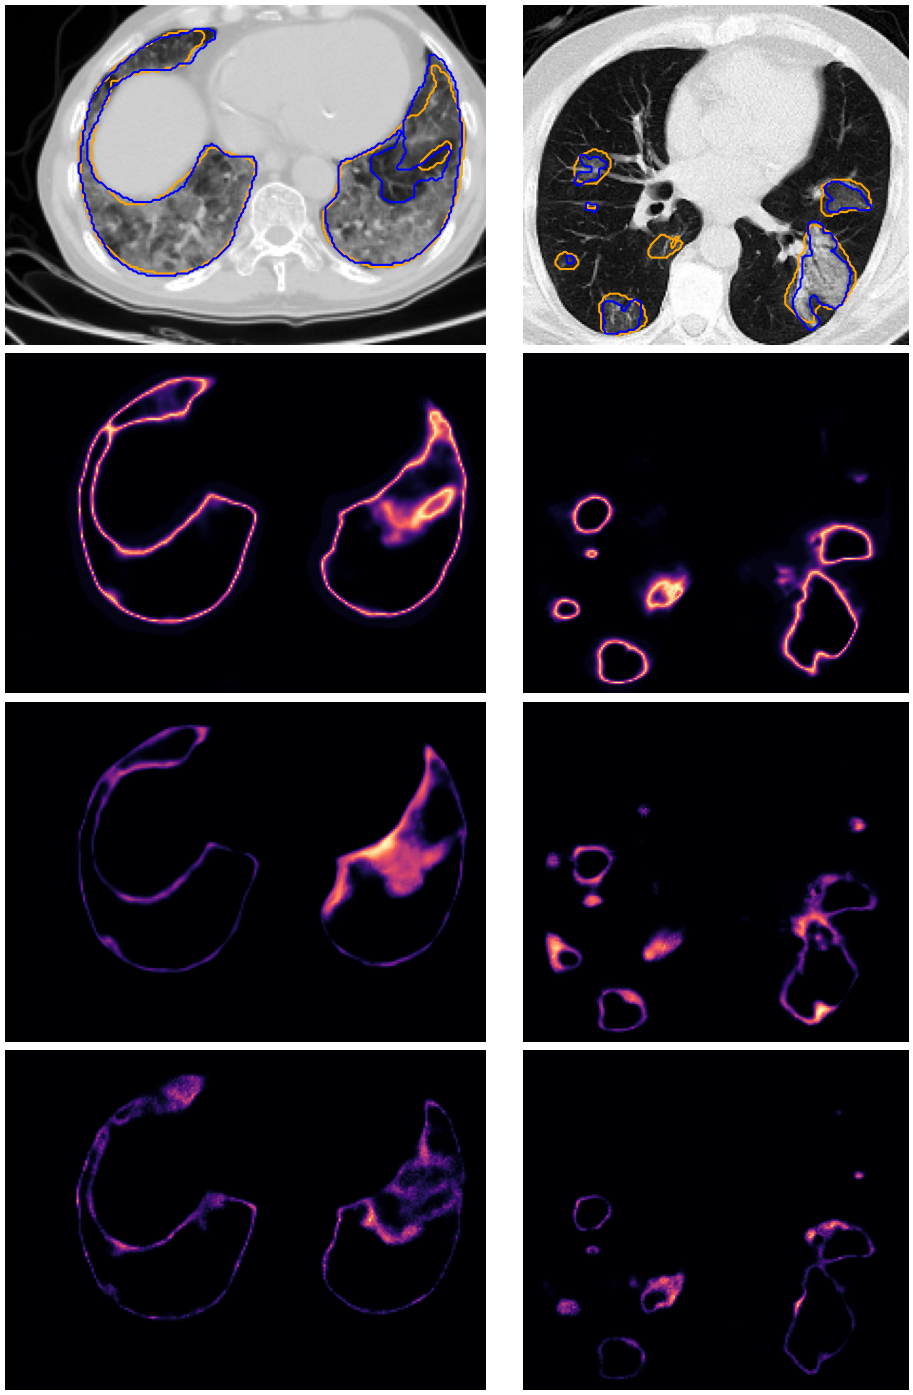

In [416]:
# [0]: 274 (axis=-1), 355 (axis=0) T 
# [1]: 310 (axis=-1), 411 (axis=1) T

plot_all('1.2.826.0.1.3680043.10.474.1147302139452080037190733417686299226', 160, 160, 2, False,
         '0', 355, 0, True,
         'FC07_55', 310, 2, False,
         'FC07_55', 411, 1, True,)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


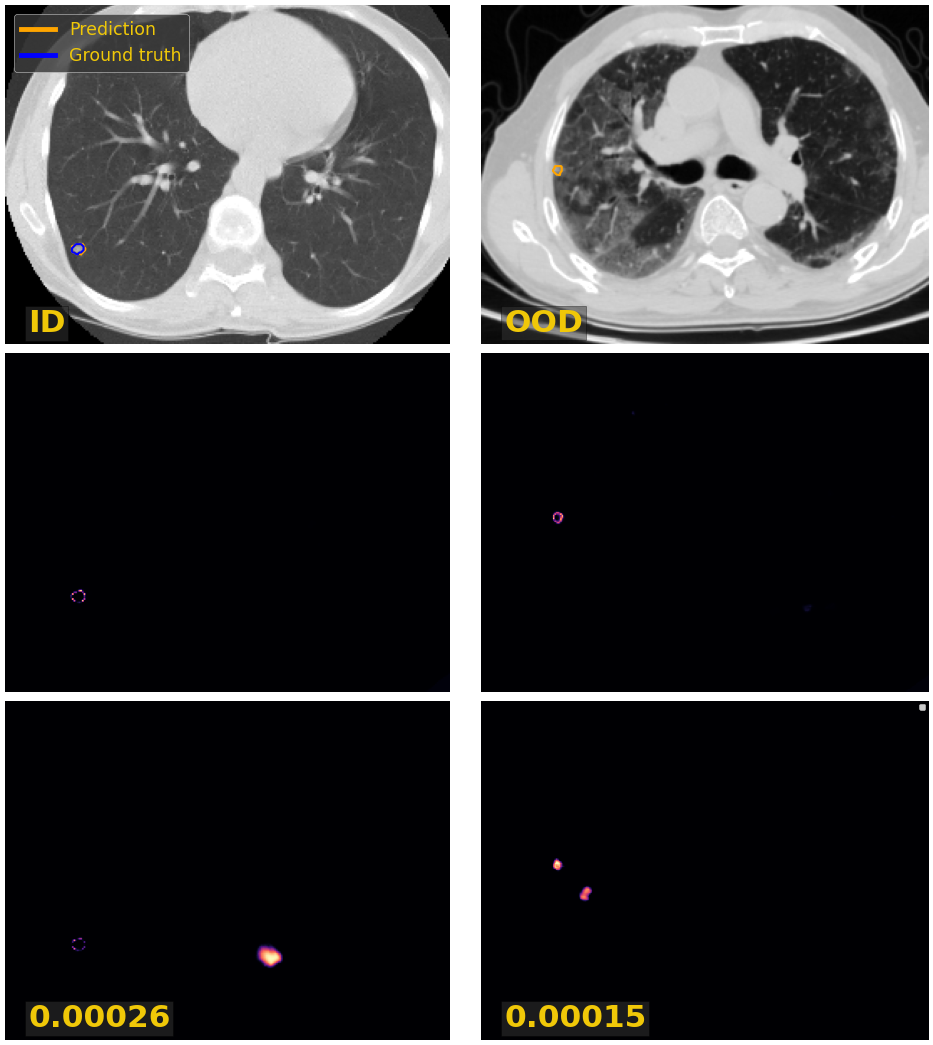

In [353]:
# [0]: 274 (axis=-1), 355 (axis=0) T 
# [1]: 310 (axis=-1), 411 (axis=1) T

plot_all('1.3.6.1.4.1.14519.5.2.1.6279.6001.270152671889301412052226973069', 133, 94, 2, False,
         '0', 355, 0, True,
         'FC07_55', 310, 2, False,
         'FC07_55', 411, 1, True,)

In [341]:
import numpy as np

from dpipe.dataset.wrappers import apply, cache_methods
from ood.dataset.cc359 import CC359
from ood.dataset.utils import Rescale3D, scale_mri
from ood.paths import CC359_DATA_PATH


data_path = CC359_DATA_PATH

# if `voxel_spacing[i]` is `None` when `i`-th dimension will be used without scaling
voxel_spacing = (1, 0.95, 0.95)
max_cache_size = 30

preprocessed_dataset = apply(Rescale3D(CC359(data_path, metadata_rpath='meta.csv'), voxel_spacing), load_image=scale_mri)
# preprocessed_dataset = apply(Rescale3D(CC359(data_path, target='hippo_mask', 
#                                              metadata_rpath='meta_upd.csv'), voxel_spacing), load_image=scale_mri)
dataset = apply(cache_methods(apply(preprocessed_dataset, load_image=np.float16), maxsize=max_cache_size), load_image=np.float32)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


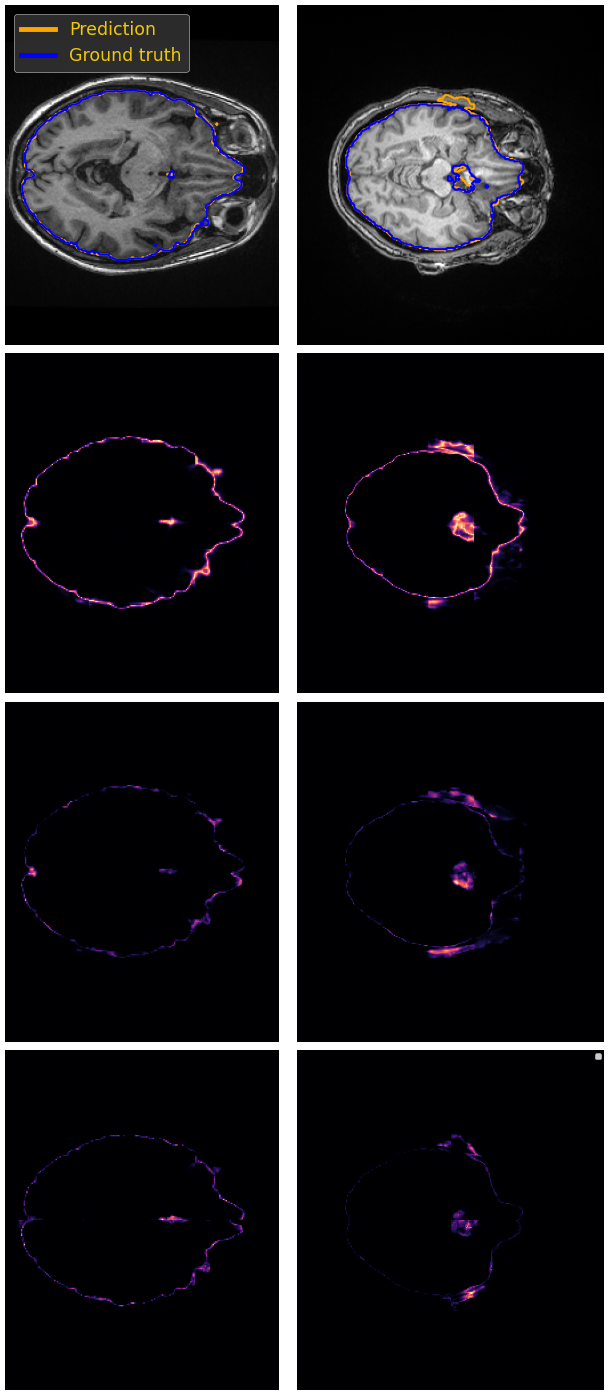

In [409]:
# [0]: 274 (axis=-1), 355 (axis=0) T 
# [1]: 310 (axis=-1), 411 (axis=1) T

plot_all('CC0241', 150, 150, 2, False,
         '0', 355, 0, True,
         'FC07_55', 310, 2, False,
         'FC07_55', 411, 1, True,)

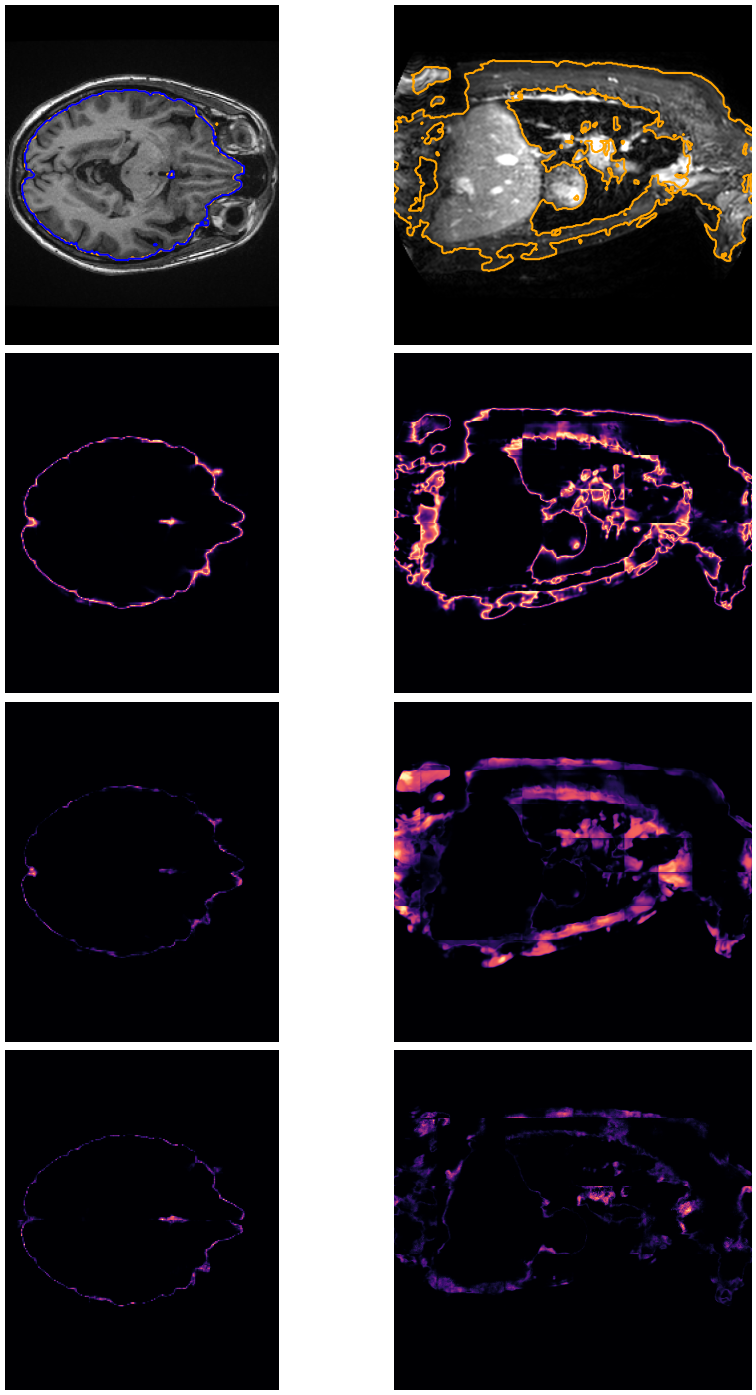

In [414]:
# [0]: 274 (axis=-1), 355 (axis=0) T 
# [1]: 310 (axis=-1), 411 (axis=1) T

plot_all('CC0241', 150, 150, 2, False,
         '0', 355, 0, True,
         'FC07_55', 310, 2, False,
         'FC07_55', 411, 1, True,)

No handles with labels found to put in legend.


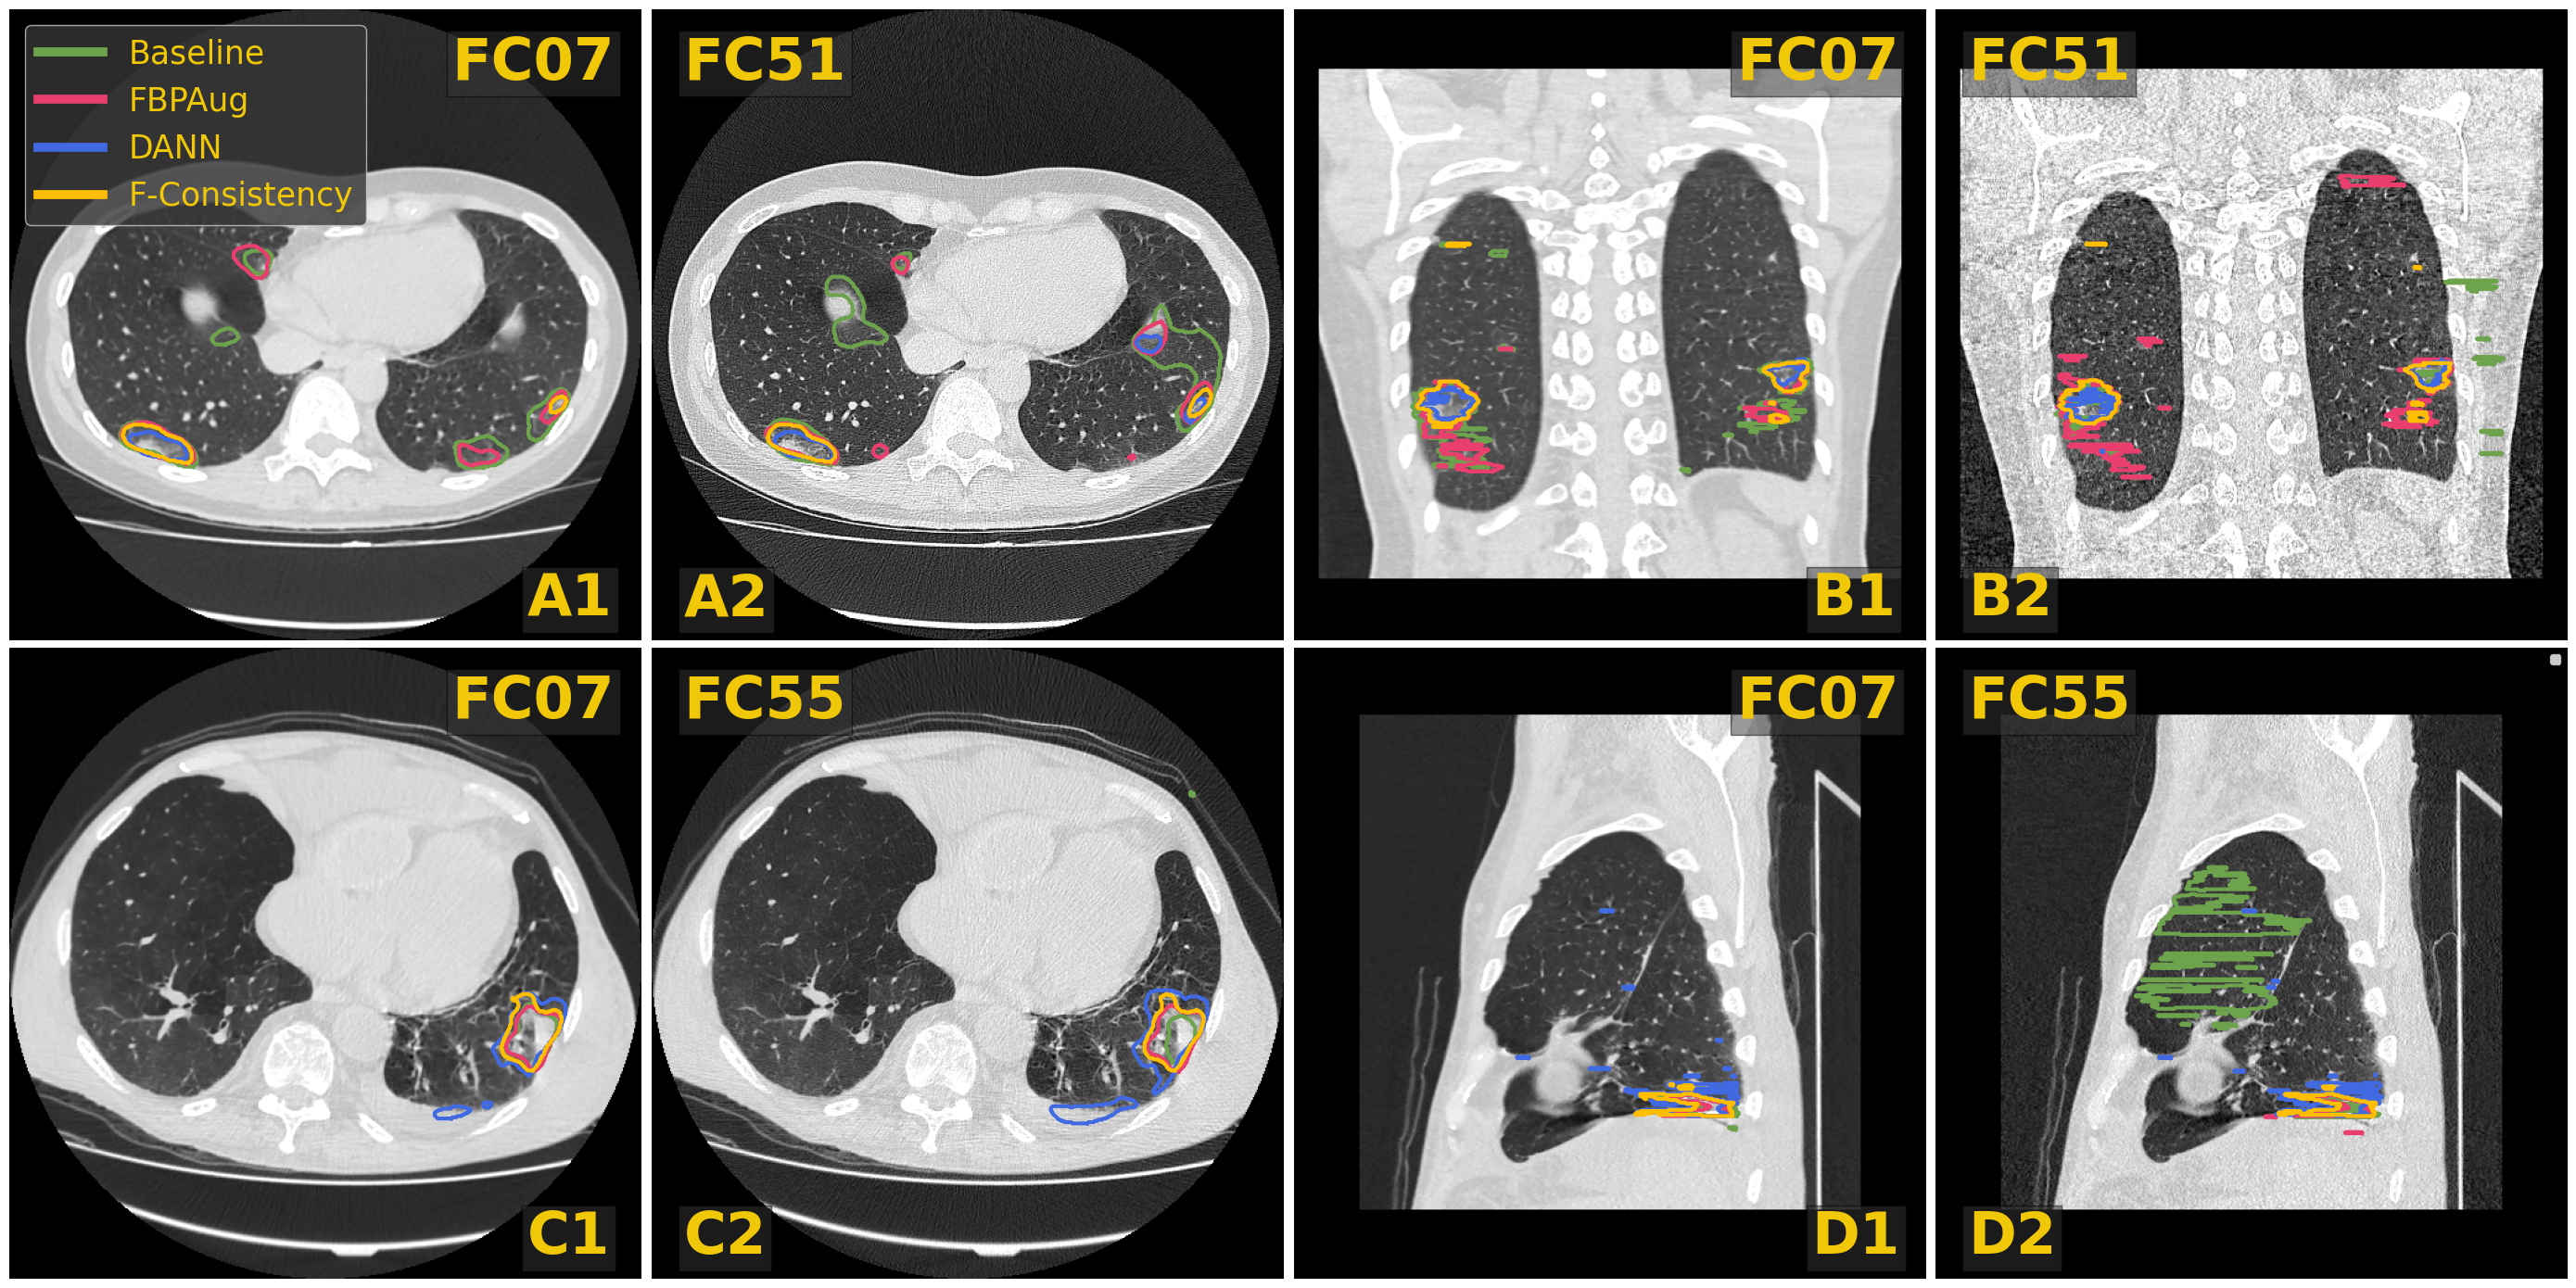

In [97]:
# [0]: 274 (axis=-1), 355 (axis=0) T 
# [1]: 310 (axis=-1), 411 (axis=1) T

plot_all('FC07_51', 274, 2, False,
         'FC07_51', 355, 0, True,
         'FC07_55', 310, 2, False,
         'FC07_55', 411, 1, True,)

In [356]:
import numpy as np

from dpipe.dataset.wrappers import apply, cache_methods
from ood.dataset.heart import Heart
from ood.dataset.utils import Rescale3D, scale_mri
from ood.paths import HEART_DATA_PATH


data_path = HEART_DATA_PATH

# if `voxel_spacing[i]` is `None` when `i`-th dimension will be used without scaling
voxel_spacing = (1, 0.95, 0.95)

preprocessed_dataset = apply(Rescale3D(Heart(data_path), voxel_spacing), load_image=scale_mri)
dataset = apply(preprocessed_dataset, load_image=np.float32)

In [363]:
uid = '10'
image = dataset.load_image(uid)
mask = np.zeros_like(image)

save(image, os.path.join(pred_path, 'CC0241', f'image_{uid}.npy'))
save(mask, os.path.join(pred_path, 'CC0241', f'mask_{uid}.npy'))